# Prediction Model using XGBoost
The files have been generated in Databricks and provided on the S3 bucket

In [ ]:
#!pip install boto3 # not required for Jupyter Notebooks on AWS infrastructure

In [2]:
import boto3

boto_session = boto3.Session() # Grabs session details directly from aws configuration in EC2 instance running the Notebook server
boto_session

Session(region_name='eu-central-1')

In [3]:
# Define variables for paths
s3_path = f"s3://sjf-project/"
output_path = s3_path + "estimator"

print(f"Using bucket '{s3_path}'.")

Using bucket 's3://sjf-project/'.


In [4]:
#!pip install sagemaker
import sagemaker

# Create a SageMaker Session
sagemaker_session = sagemaker.Session(boto_session=boto_session)

#The following IAM role ARN was taken from the flutz notebook listed in the SageMaker console:
sm_execution_role = 'arn:aws:iam::898627427171:role/service-role/AmazonSageMaker-ExecutionRole-20201106T104926'

In [5]:
# Use a previously-built, AWS XGBoost model for training

from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(***insert correct arguments here***) 

container = get_image_uri(region_name=boto_session.region_name,
                          repo_name='xgboost',
                          repo_version='1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [6]:

# From https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html 
# XGBoost ecr path is: 492215442770.dkr.ecr.eu-central-1.amazonaws.com
ecr_path = '492215442770.dkr.ecr.eu-central-1.amazonaws.com'

#'ml.m4.xlarge') | 'ml.t2.medium' || train_instance_type= "ml.m5.large" -> "ml.m5.xlarge"
#Instance Name	vCPU	ECU	RAM   	Instance-GB	Linux/UNIX-Nutzung
#t2.medium	2	Var.	4 GiB	Nur EBS 	0,0536 USD pro Stunde
#m4.xlarge	4	13	16 GiB	Nur EBS 	0,24 USD pro Stunde
#m5.large	2	10	8 GiB	Nur EBS 	0,115 USD pro Stunde
#m5.xlarge	4	16	16 GiB	Nur EBS 	0,23 USD pro Stunde
xgboost = sagemaker.estimator.Estimator(f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3",
                              sm_execution_role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.xlarge",
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              base_job_name="sjf-xgboost")


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [7]:
# Create pointers to the S3 train and test datasets
#the following files are available on the S3 bucket
#train , valid and test
#series suffixes:
# _sample.csv - small initial dataset series
# _data_trial.csv - larger intermediate dataset series
# _data_avg.csv - intermediate dataset series with "average rating" as target
# _data_weighted.csv - intermediate dataset series with "weighted rating" as target
# _data.csv - final dataset series with "average rating" as target
from sagemaker.session import s3_input

Train = 'train_data.csv'
Valid = 'valid_data.csv'

s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{Train}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{Valid}", content_type="text/csv")
#s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}train_sample.csv", content_type="text/csv")
#s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}valid_sample.csv", content_type="text/csv")
#s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}test.csv", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [8]:
# Create an XGBoost Estimator

# From https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html 
# XGBoost ecr path is: 492215442770.dkr.ecr.eu-central-1.amazonaws.com
ecr_path = '492215442770.dkr.ecr.eu-central-1.amazonaws.com'

#'ml.m4.xlarge') | 'ml.t2.medium' || train_instance_type= "ml.m5.large" -> "ml.m5.xlarge"
#Instance Name	vCPU	ECU	RAM   	Instance-GB	Linux/UNIX-Nutzung
#t2.medium	2	Var.	4 GiB	Nur EBS 	0,0536 USD pro Stunde
#m4.xlarge	4	13	16 GiB	Nur EBS 	0,24 USD pro Stunde
#m5.large	2	10	8 GiB	Nur EBS 	0,115 USD pro Stunde
#m5.xlarge	4	16	16 GiB	Nur EBS 	0,23 USD pro Stunde
xgboost = sagemaker.estimator.Estimator(f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3",
                              sm_execution_role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.xlarge",
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              base_job_name="sjf-xgboost")


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [9]:
# Select the your specific hyperparameters (Optional)

# From https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

xgboost.set_hyperparameters(
    eta=0.3,                         # default 0.3 range 0 - 1   
    num_round=500,                    # required | valid values: int | The number of rounds to run the training.
    objective = 'reg:squarederror'  # Examples: reg:linear, reg:logistic, multi:softmax, reg:squarederror [default] 
)

In [10]:
# Fit the model

xgboost.fit({"train": s3_input_train})


2020-11-20 19:39:24 Starting - Starting the training job...
2020-11-20 19:39:25 Starting - Launching requested ML instances.........
2020-11-20 19:40:58 Starting - Preparing the instances for training...
2020-11-20 19:41:33 Downloading - Downloading input data...
2020-11-20 19:42:15 Training - Training image download completed. Training in progress.......INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:42:23] 401132x430 matrix with 172486760 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train

In [11]:
# Deploy your model to an endpoint to perform predictions

Predictor = xgboost.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')
    

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [12]:
Predictor.endpoint

'sjf-xgboost-2020-11-20-19-39-23-963'

In [13]:
# Configure the predictor's serializer and deserializer

from sagemaker.predictor import csv_serializer, csv_deserializer

Predictor.serializer = csv_serializer
Predictor.deserializer = csv_deserializer
Predictor.content_type = "text/csv"

In [14]:
Predictor.endpoint

'sjf-xgboost-2020-11-20-19-39-23-963'

# Predictions

In [15]:
# Import the validate dataset into a dataframe

import pandas as pd

validate_df = pd.read_csv(f"{s3_path}{Valid}", header=None)
#display(validate_df)

In [16]:
#train_df = pd.read_csv(f"{s3_path}{Train}", header=None, skiprows=lambda n: n%4)
#display(train_df)

In [17]:
validate_df.iloc[0, 1:]

1      1668.0
2         0.0
3      1894.0
4      1894.0
5         1.0
        ...  
426       0.0
427       0.0
428       0.0
429       0.0
430       0.0
Name: 0, Length: 430, dtype: float64

In [18]:
# large number of rows result in lage amount of data that exceeds the memory limitations.
# To avoid this, predictions need to be made of single rows using a for loop. 

results=[]
for i in range(0,validate_df.shape[0]):
    if i %100==0:
        print(end='.')
    results.append(float(Predictor.predict(validate_df.loc[i, 1:].values)[0][0]))

#display(y_predicted)
#for i in range(10):
#    print(validate_df.loc[i,1:])

results

..........

[6.197003364562988,
 5.1070637702941895,
 5.238251209259033,
 4.727090835571289,
 5.152473449707031,
 4.861521244049072,
 4.741931915283203,
 4.810281753540039,
 4.742867946624756,
 4.727090835571289,
 4.727090835571289,
 4.810281753540039,
 4.727090835571289,
 4.810281753540039,
 4.672379970550537,
 5.121436595916748,
 4.727090835571289,
 4.753612518310547,
 5.0763959884643555,
 5.172580242156982,
 5.194918155670166,
 5.306822299957275,
 4.548255443572998,
 4.475616455078125,
 4.764427185058594,
 5.070497989654541,
 5.544395923614502,
 5.508101940155029,
 4.49135684967041,
 5.512868881225586,
 5.274921417236328,
 6.629620552062988,
 6.179859161376953,
 5.7525105476379395,
 5.265076637268066,
 5.78808069229126,
 6.300314903259277,
 6.1192779541015625,
 6.052771091461182,
 5.800025463104248,
 7.480260848999023,
 5.010468006134033,
 5.668325424194336,
 6.233394145965576,
 5.670629501342773,
 5.218195915222168,
 5.752740383148193,
 5.763985633850098,
 5.889714241027832,
 5.855078220367432

In [19]:
#prediction = Predictor.predict(validate_df.iloc[0:, 1:].values)
#len(prediction[0])
print(validate_df.shape)

(1000, 431)


In [20]:
y_predicted = results

In [21]:
#y_predicted = list(map(lambda pred: round(float(pred),1), prediction[0])) # prediction-Werte werde auf eine Kommastelle gerundet
#y_predicted = list(map(float, prediction[0]))
#display(y_predicted)

In [22]:
y_true = validate_df[0].values
display(y_true)

array([5.4, 4.7, 5.5, 4.2, 4.5, 7.8, 3.7, 4. , 4.2, 4.1, 4. , 4.6, 5.4,
       5.6, 4.4, 4.5, 5.6, 5.4, 5.1, 5.1, 4.9, 5.4, 4.7, 4.8, 6.1, 5.3,
       5.4, 6.9, 3.8, 5.5, 5.4, 6.9, 6. , 5.9, 5.9, 5.8, 5.8, 7.2, 4.1,
       5.8, 8.2, 4.7, 4.7, 7.3, 5. , 6.2, 6.7, 8.1, 5.7, 6.8, 5.5, 5.8,
       4.7, 5.5, 4.8, 5.3, 4.6, 5. , 5.7, 6. , 5.8, 6.2, 5.4, 5.4, 4.5,
       4.3, 4.8, 6.4, 4.8, 5.3, 6.8, 5.3, 4.4, 3.8, 4.6, 6.2, 7.8, 4.5,
       4.6, 6.2, 4.7, 4.7, 4.6, 5.7, 5.6, 5. , 5.9, 5.8, 4.3, 4.6, 4.5,
       5.5, 6.4, 4.9, 4.4, 3.6, 5.8, 4.5, 7. , 6.4, 4.8, 7.2, 5.8, 5.2,
       5.4, 5.6, 6.2, 4.6, 4.8, 5.9, 4.9, 4.1, 5.6, 4.5, 7.7, 4.4, 5.6,
       3.9, 5.7, 4.8, 4.2, 3.4, 4.2, 5.2, 4.1, 5.3, 5.4, 5.3, 6.2, 5.2,
       4. , 5.1, 5.7, 5.4, 6.2, 5.2, 8.5, 5.2, 4.7, 6. , 4. , 6.1, 5.6,
       6.7, 7.2, 4.2, 5.6, 6. , 5.7, 5.2, 5.2, 6. , 5.9, 4.8, 4.5, 5.9,
       6.1, 5.3, 5.2, 5.8, 6.1, 6.8, 5.7, 4.5, 4.7, 4.9, 6.5, 5.7, 5.6,
       5.7, 5.7, 5.2, 5.7, 4.6, 8.1, 5.8, 4.8, 3.8, 7.7, 5. , 5.

In [23]:
from sklearn.metrics import r2_score
print(r2_score(y_true, y_predicted))

0.22638118047625977


In [24]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_true, y_predicted))

0.23094015771862975


In [25]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_predicted)
print(mse)

0.9177910106804874


In [26]:
import numpy as np
rootMeanSquaredError = np.sqrt(mse)
print("RMSE:", rootMeanSquaredError)

RMSE: 0.9580140973286809


In [27]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_true, y_predicted))

0.6843818029403687


In [28]:
pred=[]
pred_df = pd.DataFrame(y_predicted, columns=['prediction'])
pred_df['ground_truth']=y_true
display(pred_df.tail(10))

,prediction,ground_truth
990,6.043608,6.4
991,5.766130,4.6
992,6.243368,5.9
993,6.454740,6.1
994,5.879455,6.4
995,6.015688,6.2
996,6.235603,4.9
997,5.540967,5.3
998,6.207683,6.4
999,5.930773,6.0


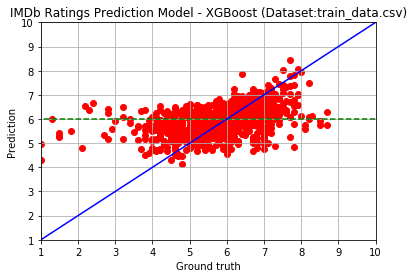

In [29]:
import matplotlib.pyplot as plt

x = y_true
y = y_predicted
plt.scatter(x, y, color="red")
plt.title(f"IMDb Ratings Prediction Model - XGBoost (Dataset:{Train})")
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.xlim([1,10])
plt.ylim([1,10])
plt.hlines(sum(pred_df['prediction'])/len(pred_df), xmin=0, xmax=10, color="green", linestyles='dashed')
plt.plot([1,10],[1,10], color="blue")
plt.grid()
plt.show()

In [30]:
# Average predicted rating
print(f"Average predicted rating overall: {sum(pred_df['prediction'])/len(pred_df)}")

Average predicted rating overall: 5.985343128204346


# Dream_Movie

In [31]:
# "dream_movie", filename will be "dream_movie.csv"
Dream = 'dream_movie.csv'
dream_df = pd.read_csv(f"{s3_path}{Dream}", header=None)
display(dream_df)

,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,427,428,429,430
0,NaN,1,0,2021,2021,55,1234,60,0,0,...,0,0,0,1,0,0,0,0,1,1


In [32]:
#Predict the rating of our Dream_Movie
dream_rating = float(Predictor.predict(dream_df.loc[0, 1:].values)[0][0])
print(dream_rating)

7.556224346160889


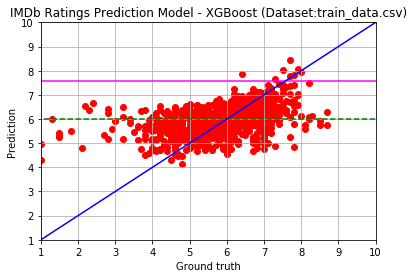

In [33]:
plt.scatter(x, y, color="red")
plt.title(f"IMDb Ratings Prediction Model - XGBoost (Dataset:{Train})")
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.xlim([1,10])
plt.ylim([1,10])
plt.hlines(sum(pred_df['prediction'])/len(pred_df), xmin=0, xmax=10, color="green", linestyles='dashed')
plt.hlines(dream_rating, xmin=0, xmax=10, color="magenta", linestyles='solid')
plt.plot([1,10],[1,10], color="blue")
plt.grid()
plt.show()